In [ ]:
%%capture
! pip install -q equinox optax

In [ ]:
! git remote remove origin
! git init .
! git remote add origin https://@github.com/arudikov/PNO
! git pull origin main

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import jax
import optax
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt

from datasets.Elliptic import solvers
from architectures.DilResNet import DilatedResNet
from collections import namedtuple
from tqdm import tqdm
from IPython import display
from jax import config, random, grad, jit, hessian, vmap
from jax.lax import scan
from functools import partial
from jax.scipy.optimize import minimize

config.update("jax_enable_x64", True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
@jit
def derivative(a, h):
    '''
    find derivative of a 1D functions given on uniform grid x
    a.shape = (N_x)
    h = grid spacing
    '''
    d_a = (jnp.roll(a, -1, axis=0) - jnp.roll(a, 1, axis=0)) / (2*h)
    d_a = d_a.at[0].set((-3*a[0]/2 + 2*a[1] - a[2]/2)/h) # 1/2	−2	3/2
    d_a = d_a.at[-1].set((a[-3]/2 - 2*a[-2] + 3*a[-1]/2)/h) # 1/2	−2	3/2
    return d_a

In [ ]:
def dataset(N_points, key):
    coeffs = []
    for key in iter(random.split(key, 4)):
        coeffs.append(random.normal(key, (5,), dtype=jnp.complex128))

    a = lambda x: -(jnp.real(0.5 * jnp.sum(jnp.stack([jnp.exp(1j * 2 * jnp.pi * x * k) * coeffs[0][k] for k in range(coeffs[0].size)], 0), 0))**2 + 0.5)
    d = lambda x: jnp.zeros_like(x)
    c = lambda x: jnp.real(0.2 * jnp.sum(jnp.stack([jnp.exp(1j * 2 * jnp.pi * x * k) * coeffs[1][k] for k in range(coeffs[1].size)], 0), 0))
    f = lambda x: jnp.real(jnp.sum(jnp.stack([jnp.exp(1j * 2 * jnp.pi * x * k) * coeffs[2][k] for k in range(coeffs[2].size)], 0), 0))

    F = [a, d, c, f]
    BCs = [0, 0]
    
    x = jnp.linspace(0, 1, N_points)
    features = jnp.vstack((-a(x), c(x), f(x)))
    solution = solvers.solve_BVP(N_points, F, BCs)

    return x, features, solution

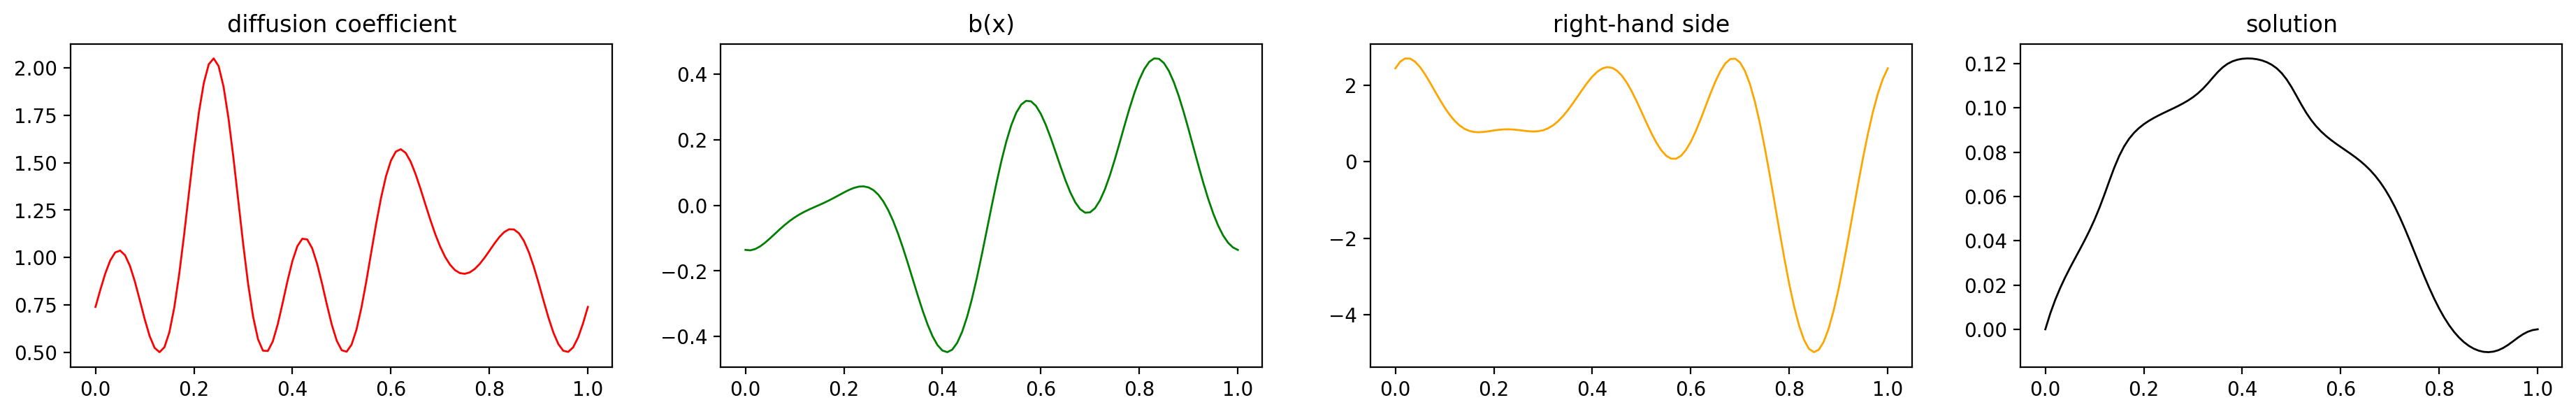

In [ ]:
key = random.PRNGKey(42)

N_points = 101
x, features, solution = dataset(N_points, key)

fig, ax = plt.subplots(1, 4, figsize=(23, 3))
colors = ['red', 'green', 'orange', 'black']

for i, (v, n) in enumerate(zip([*features, solution], [r"diffusion coefficient", r"b(x)", r"right-hand side", r"solution"])):
    ax[i].set_title(n)
    ax[i].plot(x, v, color=colors[i], linewidth=1.0);

In [ ]:
def loss_with_boudaries(y, u, a, b, f, C_f):
    def upper_bound(y, u, a, b, f, C_f):
        dy = derivative(y, 1 / N_points)
        du = derivative(u, 1 / N_points)
        return jnp.sqrt(jnp.trapz((y - a * du)**2 / a, dx=1/N_points)) + C_f * jnp.sqrt(jnp.trapz((f + dy - b * u)**2, dx=1/N_points))
    return upper_bound(y, u, a, b, f, C_f)  + 1e1 * jnp.sqrt(u[0]**2 + u[-1]**2)

def J(a, b, u1, u2):
    d_u1 = derivative(u1, 1/N_points)
    d_u2 = derivative(u2, 1/N_points)
    return jnp.sqrt(jnp.trapz(a * (d_u1 - d_u2)**2 + b * (u1 - u2)**2, dx=1/N_points))


def compute_loss(model, input):
    output = vmap(lambda z: model(z), in_axes=(0,))(input)
    u, y = output[:, 0], output[:, 1]
    a, b, f = input[:, 0], input[:, 1], input[:, 2]
    C_f = jnp.max(a, axis=1) / jnp.pi

    loss = jnp.mean(vmap(loss_with_boudaries, in_axes=(0, 0, 0, 0, 0, 0))(y, u, a, b, f, C_f))
    return loss

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, input, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, input)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
N_samples = 600
features, targets = [], []

dataset_ = partial(dataset, N_points=101)
for i in tqdm(range(N_samples)):
    key = random.PRNGKey(i)
    x, feature, solution = dataset_(key=key)
    features.append(feature)
    targets.append(solution)

features = jnp.array(features)
targets = jnp.array(targets)

100%|██████████| 600/600 [09:11<00:00,  1.09it/s]


In [ ]:
features.shape, targets.shape

((600, 3, 101), (600, 101))

In [ ]:
def batch_generator(x, batch_size, key, shuffle=True):
    N_samples = len(x)
    list_of_indeces = jnp.linspace(0, N_samples-1, N_samples, dtype=jnp.int64)
    if shuffle:
       random.shuffle(key, list_of_indeces)
    
    list_x = x[list_of_indeces]

    n_batches = N_samples // batch_size

    if N_samples % batch_size != 0:
        n_batches += 1

    for k in range(n_batches):
        this_batch_size = batch_size
        if k == n_batches - 1:
            if N_samples % batch_size > 0:
                this_batch_size = N_samples % batch_size

        this_x = list_x[k * batch_size : k * batch_size + this_batch_size]
        x = jnp.array(this_x)

        yield x

In [ ]:
def train_on_epoch(train_generator, model, optimizer, opt_state, n_iter):
    epoch_loss = []
    for it, (batch_of_x) in enumerate(train_generator):
        batch_loss, model, opt_state = make_step(model, batch_of_x, optimizer, opt_state)
        epoch_loss.append(batch_loss.item())
        n_iter += 1
        
    return epoch_loss, model, opt_state, n_iter

In [ ]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset_x,
            model, 
            lr,
            callback = None):
  
    loss =  compute_loss(model, dataset_x[0])
    history = [loss.item(), ]

    c = dataset_x[0].shape[0] // batch_size
    dict_lr = {50 * c : 0.5, 100 * c : 0.5, 150 * c : 0.5, 200 * c : 0.5, 
               250 * c : 0.5, 300 * c : 0.5, 350 * c : 0.5, 400 * c : 0.5, 
               450 * c : 0.5, 500 * c : 0.5, 550 * c : 0.5, 600 * c : 0.5, 
               650 * c : 0.5, 700 * c : 0.5, 750 * c : 0.5, 800 * c : 0.5, 
               850 * c : 0.5, 900 * c : 0.5, 950 * c : 0.5, 1000 * c : 0.5}
    
    sc = optax.piecewise_constant_schedule(lr, dict_lr)
    optimizer = optax.experimental.split_real_and_imaginary(optax.adamw(sc, weight_decay=1e-2))
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': jnp.nan})
    n_iter = 0
    
    for it in iterations:
        key = random.PRNGKey(it)
        generator = tqdm(batch_generator(x=dataset_x[0], batch_size=batch_size, key=key, shuffle=True), desc='Loading', disable=False,
                        total=len(dataset_x[0]) // batch_size + (len(dataset_x[0]) % batch_size > 0))
        
        epoch_loss, model, opt_state, n_iter = train_on_epoch(train_generator=generator, 
                    model=model, 
                    optimizer=optimizer,
                    opt_state = opt_state,
                    n_iter = n_iter)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})
        history.append(jnp.array(epoch_loss).mean())

        a, b = features[:, 0], features[:, 1]
        ouput = vmap(model)(features)[:, 0]
        energy_norm = vmap(J, in_axes=(0, 0, 0, 0))(a, b, targets, ouput)
        
        display.clear_output(wait=True)
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))

        axes[0].set_title(r'Loss')
        axes[0].set_yscale("log")
        axes[0].plot(history, color='red')

        axes[1].set_title("Energy norm")
        axes[1].set_yscale("log")
        axes[1].plot(energy_norm, ".", color="red")

        axes[2].plot(vmap(model)(features)[:, 0][101], color='red', label='pred')
        axes[2].plot(targets[101], color='green', label='true')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    return model

In [ ]:
Config = namedtuple('Config', ['learning_rate', 'batch_size', 'count_of_epoch', 'channels', 'n_cells'])
args = Config(learning_rate=2e-3, batch_size=20, count_of_epoch=400, channels=[3, 64, 2], n_cells=5)

In [ ]:
key = random.PRNGKey(123)

x = jnp.linspace(0, 1, N_points)
N_train = int(0.9 * features.shape[0])
dataset_x = [features[:N_train], features[N_train:]]

model = DilatedResNet(key, args.channels, args.n_cells)

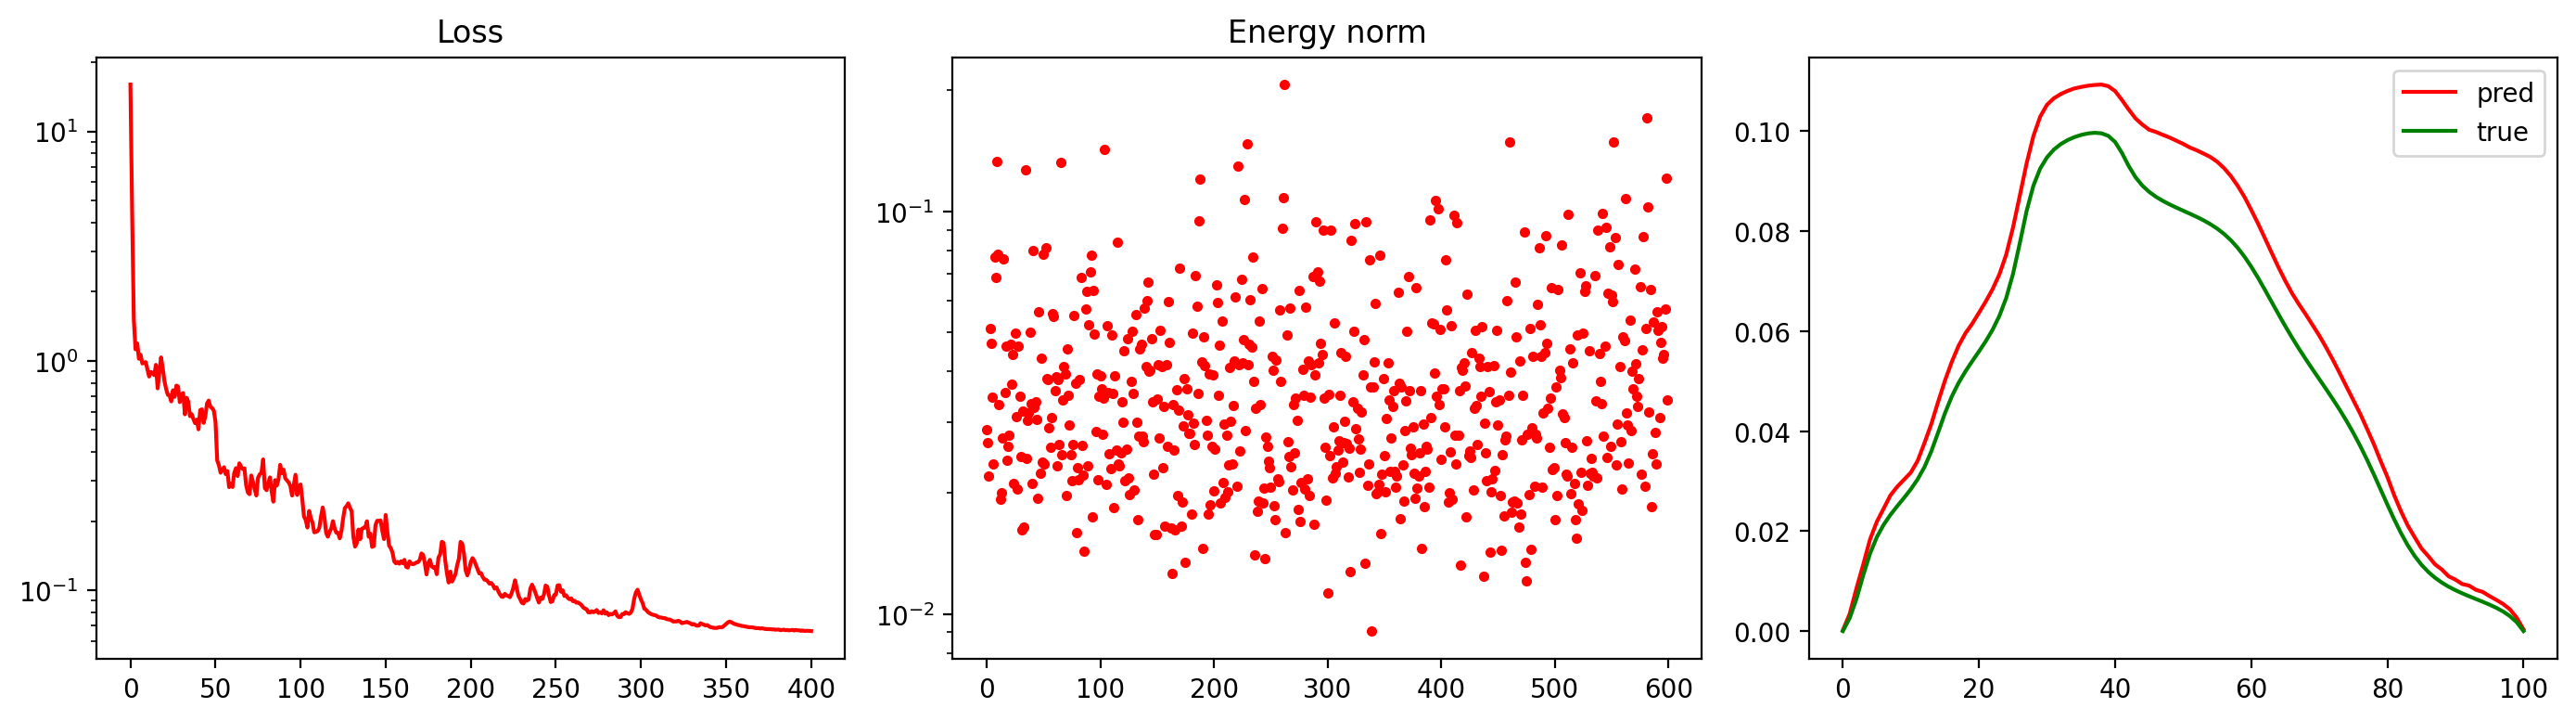

epoch: 100%|██████████| 400/400 [20:26<00:00,  3.07s/it, train epoch loss=[0.08480939088621887, 0.06606804592404256, 0.0711768835440946, 0.06710347453296578, 0.07058831850973948, 0.06630503093718006, 0.060907889922488315, 0.0665276621303981, 0.051699725172385726, 0.06990918450474413, 0.062369494521170944, 0.08228953778353537, 0.05987297489918808, 0.06988469754280917, 0.06957608874018077, 0.05977946694880355, 0.06892643833584336, 0.06112316500883391, 0.06331641862294834, 0.07068872155844579, 0.06252883279484088, 0.06410744732595212, 0.0549457444367402, 0.06208119157045292, 0.07150435811668329, 0.06442621254800765, 0.06773089143878357]]


In [ ]:
model = trainer(count_of_epoch = args.count_of_epoch,
        batch_size = args.batch_size,
        dataset_x = dataset_x,
        model = model,
        lr = args.learning_rate)

In [ ]:
prediction_train = vmap(model)(features[:N_train])[:, 0]
prediction_train = prediction_train - jnp.repeat(x[None,:], prediction_train.shape[0], axis=0) * prediction_train[:, -1][:,None]
relative_train_error = jnp.linalg.norm(prediction_train - targets[:N_train], axis=1).reshape(-1, ) / jnp.linalg.norm(targets[:N_train], axis=1).reshape(-1, )

prediction_test = vmap(model)(features[N_train:])[:, 0]
prediction_test = prediction_test - jnp.repeat(x[None,:], prediction_test.shape[0], axis=0) * prediction_test[:,-1][:,None]
relative_test_error = jnp.linalg.norm(prediction_test - targets[N_train:], axis=1).reshape(-1, ) / jnp.linalg.norm(targets[N_train:], axis=1).reshape(-1, )

print("Mean relative train error", jnp.mean(relative_train_error))
print("Mean relative test error", jnp.mean(relative_test_error))

Mean relative train error 0.15023551267690638
Mean relative test error 0.18346461003764372


In [ ]:
def energy_loss(model, input, targets):
    output = vmap(lambda x: model(x), in_axes=(0,))(input)
    u = output[:, 0]
    a, b = input[:, 0], input[:, 1]
    loss = vmap(J, in_axes=(0, 0, 0, 0))(a, b, targets, u)
    return loss

energy_loss_train = energy_loss(model, features[:N_train], targets[:N_train])
energy_loss_test = energy_loss(model, features[N_train:], targets[N_train:])

print("Mean energy loss for train ", jnp.mean(energy_loss_train))
print("Mean energy loss for test", jnp.mean(energy_loss_test))

Mean energy loss for train  0.03820958736191849
Mean energy loss for test 0.05189544610557745


In [ ]:
def compute_upper_bound_loss(model, input):
    output = vmap(lambda z: model(z), in_axes=(0,))(input)
    u, y = output[:, 0], output[:, 1]
    a, b, f = input[:, 0], input[:, 1], input[:, 2]
    C_f = jnp.max(a, axis=1) / jnp.pi

    def upper_bound(y, u, a, b, f, C_f):
        dy = derivative(y, 1 / N_points)
        du = derivative(u, 1 / N_points)
        return jnp.sqrt(jnp.trapz((y - a * du)**2 / a, dx=1/N_points)) + C_f * jnp.sqrt(jnp.trapz((f + dy - b * u)**2, dx=1/N_points))

    loss = vmap(upper_bound, in_axes=(0, 0, 0, 0, 0, 0))(y, u, a, b, f, C_f)
    return loss

bound_loss_train = compute_upper_bound_loss(model, features[:N_train])
bound_loss_test = compute_upper_bound_loss(model, features[N_train:])

print("Mean upper bound train error", jnp.mean(bound_loss_train))
print("Mean upper bound test error", jnp.mean(bound_loss_test))

Mean upper bound train error 0.06871505918189409
Mean upper bound test error 0.10680332027850131


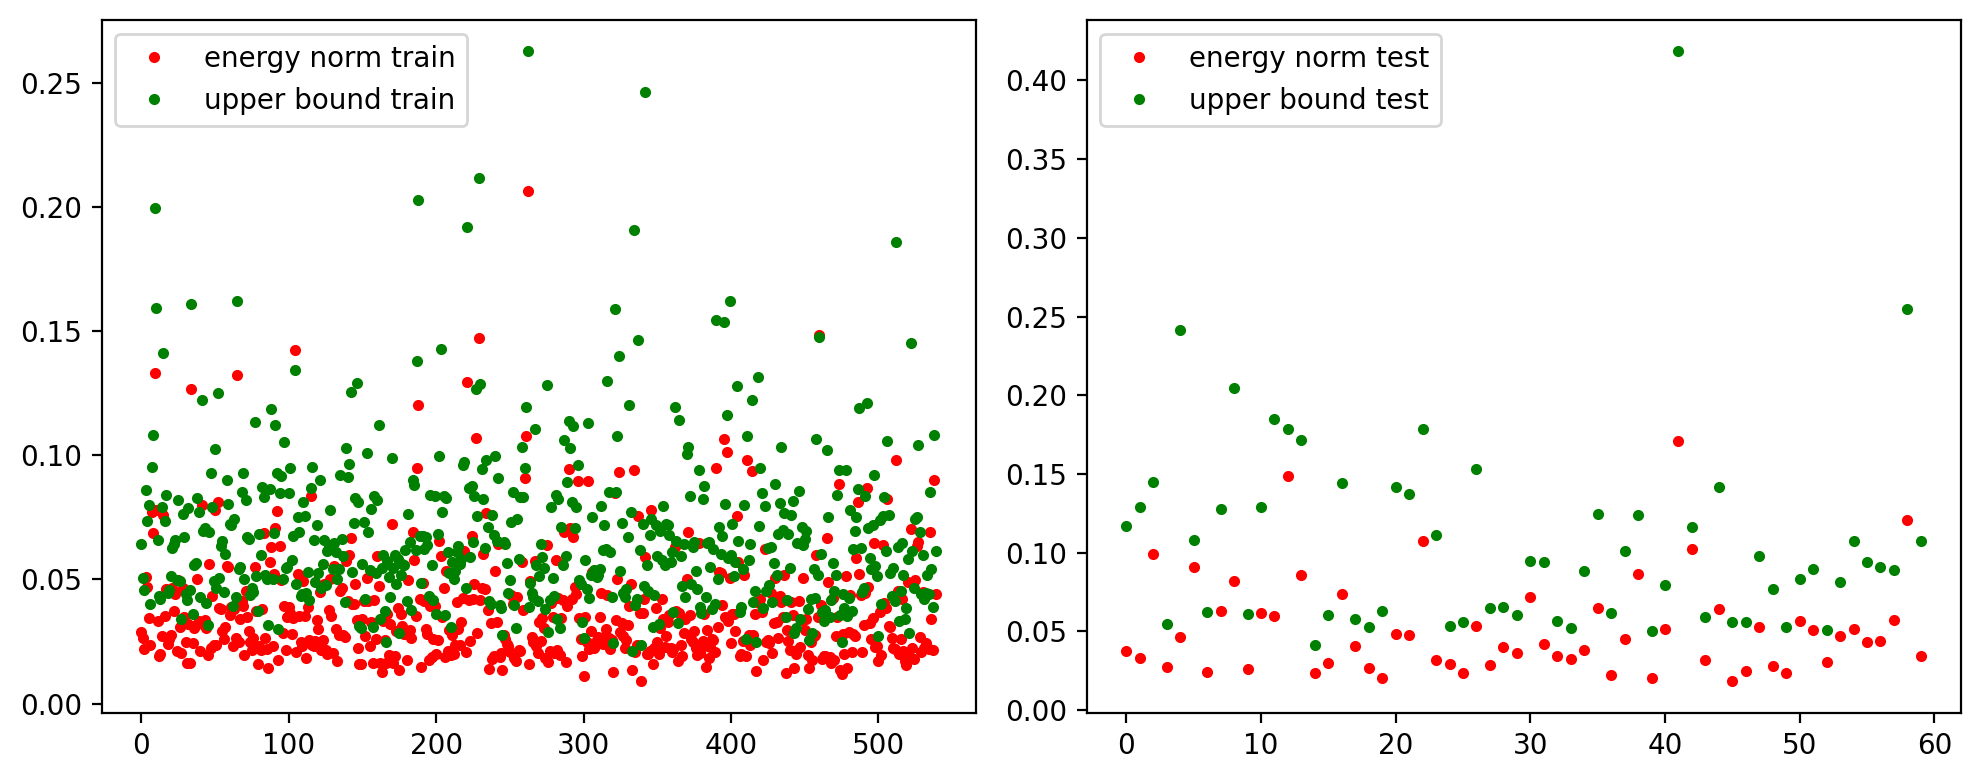

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(energy_loss_train, '.', color='red', label=r'energy norm train')
ax[0].plot(bound_loss_train, '.', color='green', label=r'upper bound train')
ax[0].legend()

ax[1].plot(energy_loss_test, '.', color='red', label=r'energy norm test')
ax[1].plot(bound_loss_test, '.', color='green', label=r'upper bound test')
ax[1].legend()

plt.tight_layout()
plt.show();